<a href="https://colab.research.google.com/github/ogueke/image_classification/blob/main/Plant_classification_project_InceptionV3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import Data Science Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers,models
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing

# System libraries
from pathlib import Path
import os.path
import random

# Visualization Libraries
import matplotlib.cm as cm
import cv2
import seaborn as sns

sns.set_style('darkgrid')

# Performance Metrics
from sklearn.metrics import classification_report, confusion_matrix
import itertools

In [2]:
#Classes of images in the dataset
dataset = '/content/drive/MyDrive/Dataset'
classlist = os.listdir(dataset)
classlist

['This is not a Plant Part',
 'African Almond Plant',
 'Avocado Plant',
 'Cashew Plant',
 'Guava Plant',
 'Mango Plant']

In [4]:
#Checking the images and their format
from pathlib import Path
import imghdr

image_extensions = [".png", ".jpg"]  #Add there all your images file extensions

img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
for filepath in Path(dataset).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")

In [3]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

--2023-08-27 12:11:09--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-08-27 12:11:09 (91.7 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [4]:
BATCH_SIZE = 32
TARGET_SIZE = (224, 224)

In [5]:
# Walk through each directory
walk_through_dir(dataset);

There are 6 directories and 0 images in '/content/drive/MyDrive/Dataset'.
There are 0 directories and 1400 images in '/content/drive/MyDrive/Dataset/This is not a Plant Part'.
There are 0 directories and 1000 images in '/content/drive/MyDrive/Dataset/African Almond Plant'.
There are 0 directories and 1000 images in '/content/drive/MyDrive/Dataset/Avocado Plant'.
There are 0 directories and 1000 images in '/content/drive/MyDrive/Dataset/Cashew Plant'.
There are 0 directories and 1000 images in '/content/drive/MyDrive/Dataset/Guava Plant'.
There are 0 directories and 1000 images in '/content/drive/MyDrive/Dataset/Mango Plant'.


In [6]:
image_dir = Path(dataset)

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

In [7]:
image_df.head(5)

,Filepath,Label
0,/content/drive/MyDrive/Dataset/African Almond ...,African Almond Plant
1,/content/drive/MyDrive/Dataset/African Almond ...,African Almond Plant
2,/content/drive/MyDrive/Dataset/African Almond ...,African Almond Plant
3,/content/drive/MyDrive/Dataset/African Almond ...,African Almond Plant
4,/content/drive/MyDrive/Dataset/African Almond ...,African Almond Plant


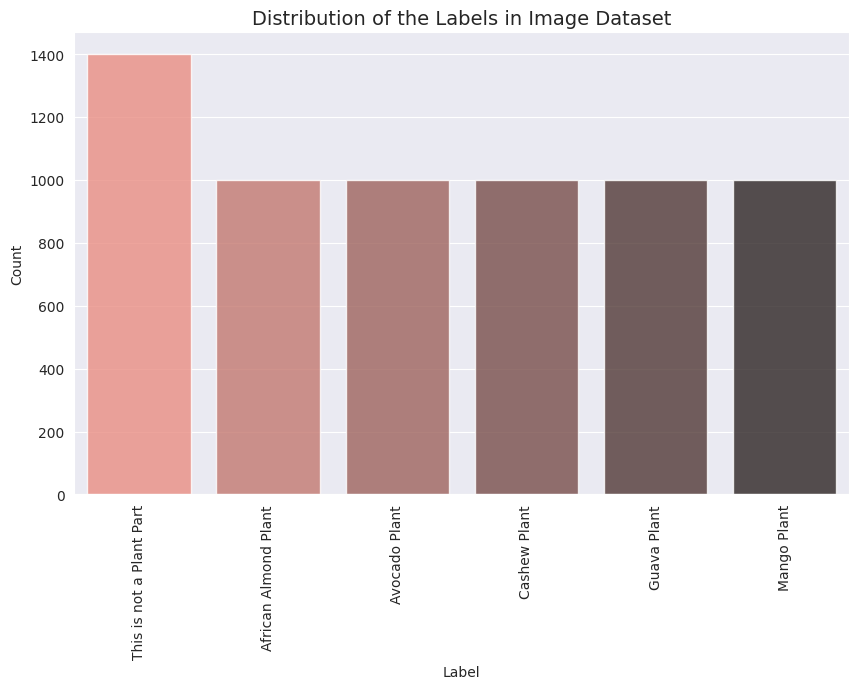

In [8]:
# Get the labels
label_counts = image_df['Label'].value_counts()[:]

plt.figure(figsize=(10, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, alpha=0.8, palette='dark:salmon_r')
plt.title('Distribution of the Labels in Image Dataset', fontsize=14)
plt.xlabel('Label', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.xticks(rotation=90)
plt.show()

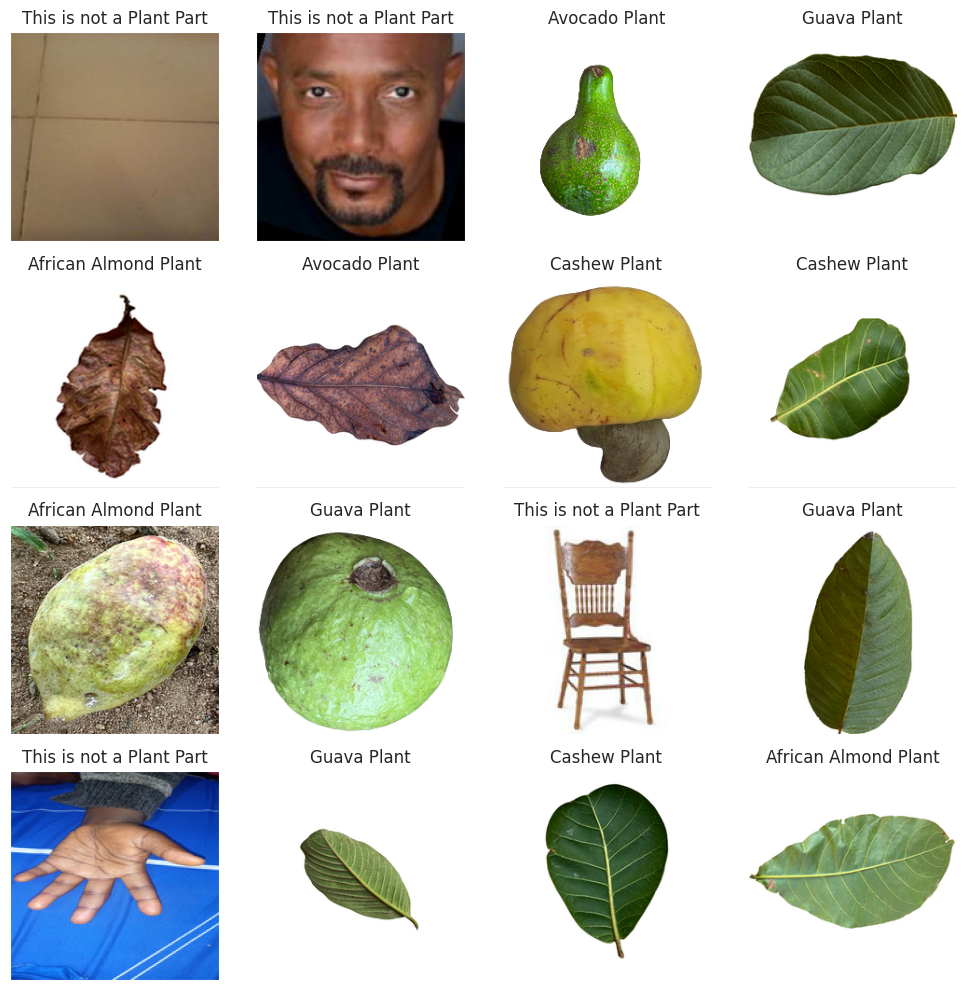

In [9]:
# Display 16 picture of the dataset with their labels
random_index = np.random.randint(0, len(image_df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

In [10]:
# Separate in train and test data (20% of total dataset)
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=42)

In [11]:
#Use 20% of the train dataset for Validation
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.inception_v3.preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.inception_v3.preprocess_input,
)

In [12]:
# Split out the data into three categories.
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 4096 validated image filenames belonging to 6 classes.
Found 1023 validated image filenames belonging to 6 classes.
Found 1280 validated image filenames belonging to 6 classes.


In [13]:
# Data Augmentation Step
augment = tf.keras.Sequential([
  #layers.experimental.preprocessing.Resizing(224,224),
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.experimental.preprocessing.RandomFlip("horizontal"),
  layers.experimental.preprocessing.RandomRotation(40),
  #layers.experimental.preprocessing.RandomZoom(0.1),
  #layers.experimental.preprocessing.RandomContrast(0.1),
])

In [ ]:
'''model = tf.keras.Sequential(
    [
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation="relu",input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),

    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation="relu"),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),

    tf.keras.layers.Conv2D(128, (3,3), padding='same', activation="relu"),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(224, activation="relu"),
    tf.keras.layers.Dense(6, activation="softmax")
]
)

model.summary()'''

In [15]:
# Load the pretained model
pretrained_model = InceptionV3(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)

pretrained_model.trainable = False

87910968/87910968 [==============================] - 1s 0us/step


In [16]:
# Create checkpoint callback
checkpoint_path = "Plants_classification_model_inceptionv3_checkpoint"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 5,
                               restore_best_weights = True) # if val loss decreases for 3 epochs in a row, stop training

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

In [17]:
#Add Fully-Connected Layers
inputs = pretrained_model.input
x = augment(inputs)

x = Dense(1024, activation='relu')(pretrained_model.output)
x = Dropout(0.45)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.45)(x)


outputs = Dense(6, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

In [18]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [19]:
model.compile(
    optimizer=Adam(0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [20]:
history = model.fit(train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images), batch_size=BATCH_SIZE, epochs=20)

Epoch 1/20
128/128 [==============================] - 1125s 9s/step - loss: 1.6106 - accuracy: 0.4214 - val_loss: 0.9188 - val_accuracy: 0.7370
Epoch 2/20
128/128 [==============================] - 22s 169ms/step - loss: 0.9574 - accuracy: 0.6318 - val_loss: 0.5371 - val_accuracy: 0.8407
Epoch 3/20
128/128 [==============================] - 21s 160ms/step - loss: 0.6811 - accuracy: 0.7500 - val_loss: 0.3762 - val_accuracy: 0.8964
Epoch 4/20
128/128 [==============================] - 22s 168ms/step - loss: 0.5614 - accuracy: 0.7925 - val_loss: 0.2975 - val_accuracy: 0.9189
Epoch 5/20
128/128 [==============================] - 20s 158ms/step - loss: 0.4644 - accuracy: 0.8357 - val_loss: 0.2534 - val_accuracy: 0.9335
Epoch 6/20
128/128 [==============================] - 21s 164ms/step - loss: 0.3863 - accuracy: 0.8628 - val_loss: 0.2234 - val_accuracy: 0.9326
Epoch 7/20
128/128 [==============================] - 20s 159ms/step - loss: 0.3354 - accuracy: 0.8804 - val_loss: 0.1794 - val_acc

In [21]:
#Model Evaluation using the test dataset
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.08588
Test Accuracy: 97.03%


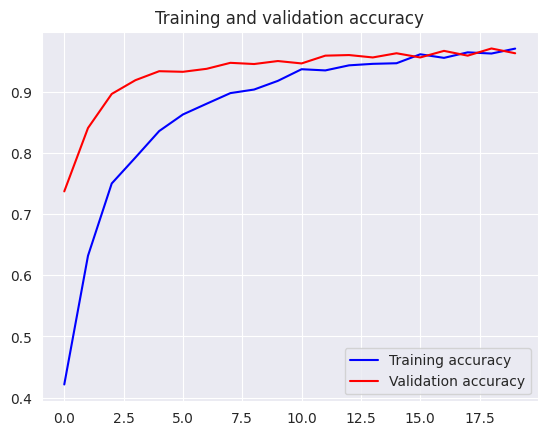

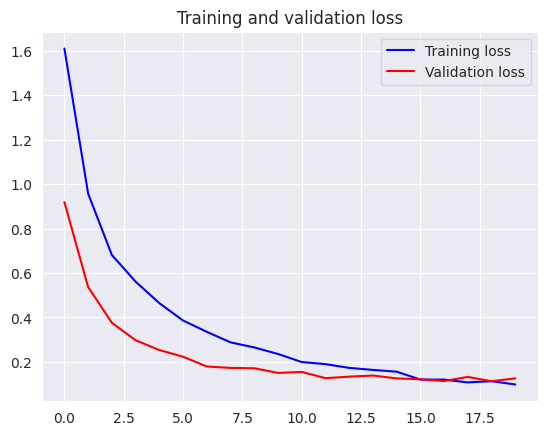

In [22]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')

plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')

plt.title('Training and validation loss')
plt.legend()
plt.show()

In [23]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

40/40 [==============================] - 8s 166ms/step
The first 5 predictions: ['Mango Plant', 'This is not a Plant Part', 'Mango Plant', 'Mango Plant', 'African Almond Plant']


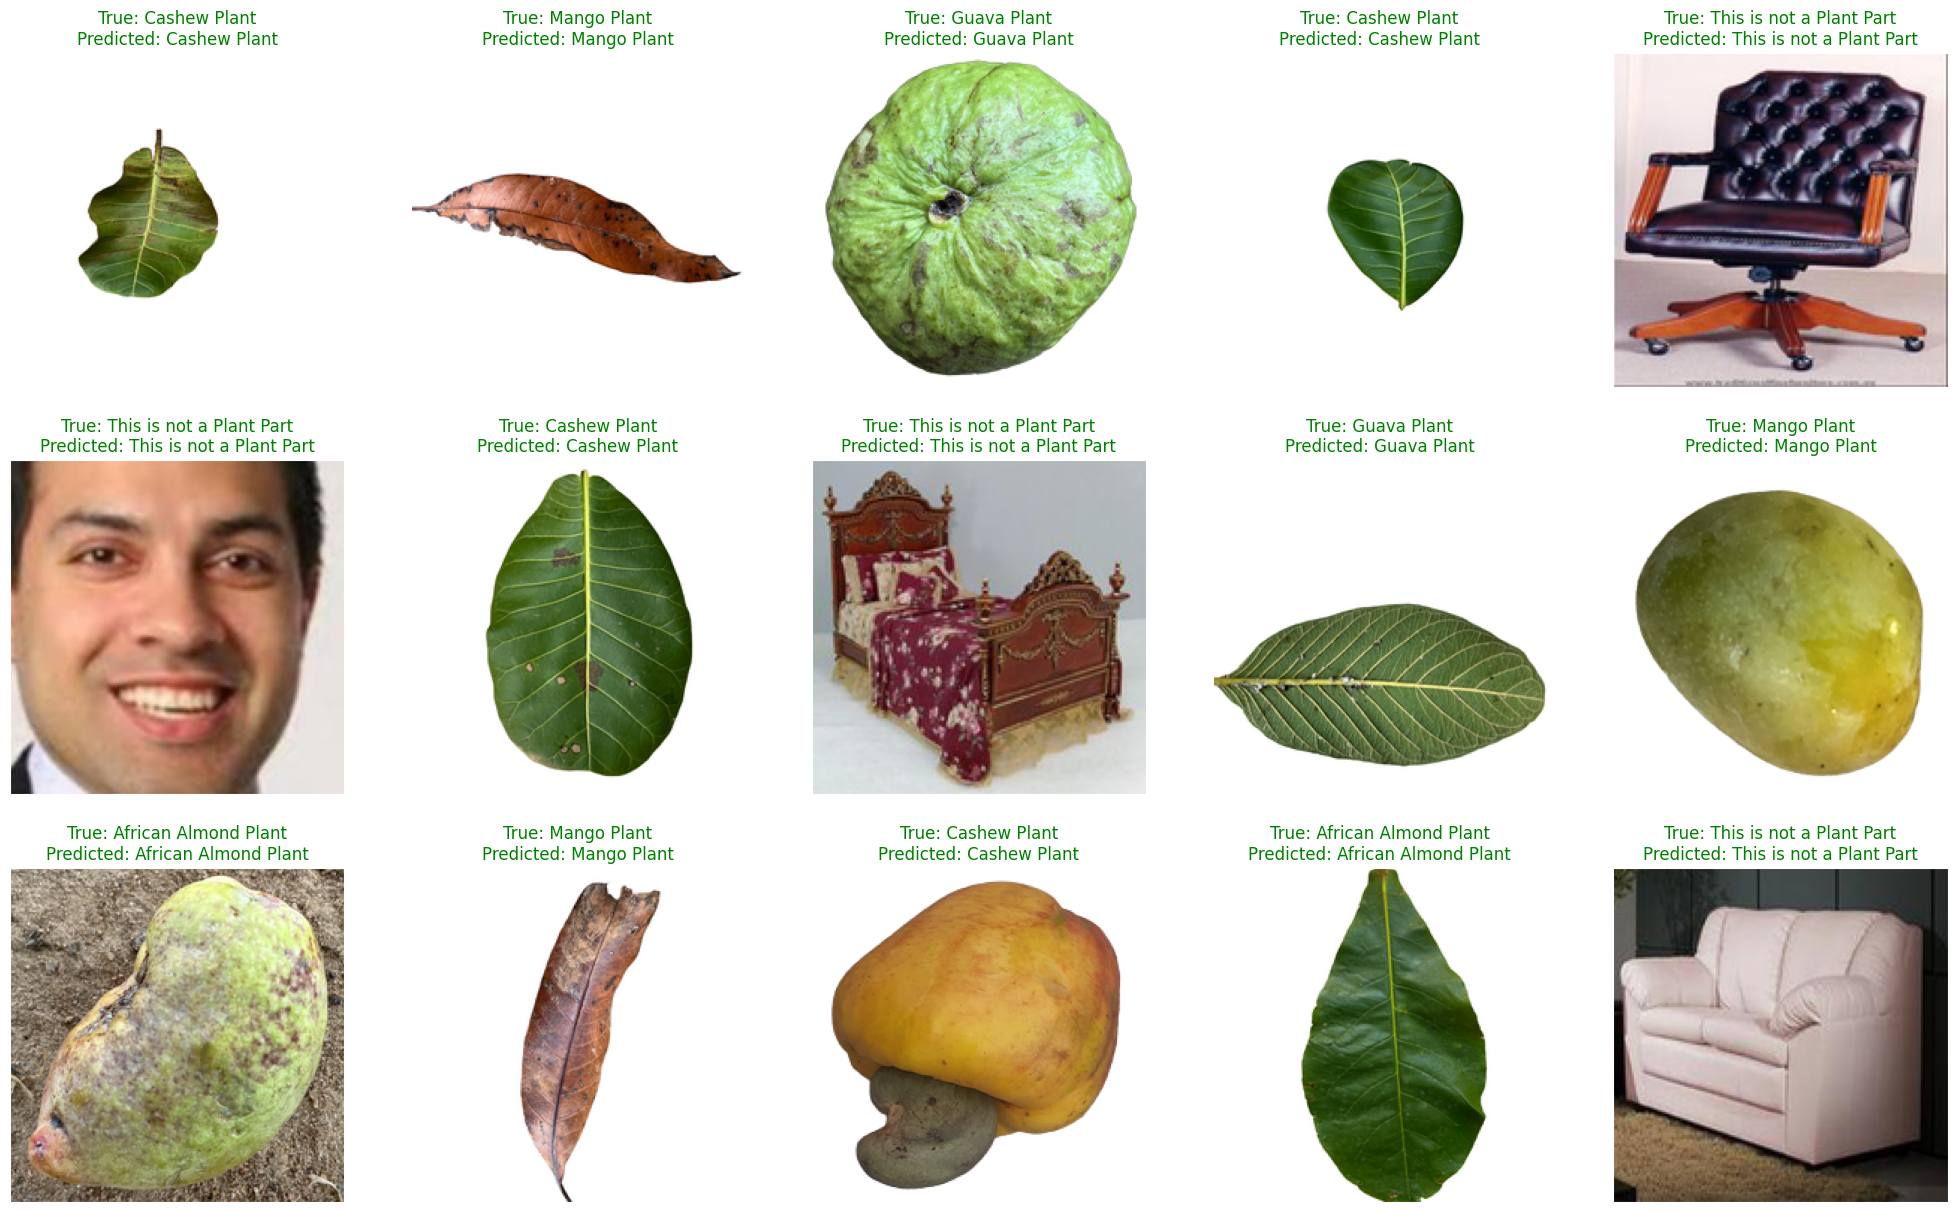

<Figure size 640x480 with 0 Axes>

In [24]:
# Display 25 random pictures from the dataset with their labels
random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[random_index[i]]))
    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
        color = "green"
    else:
        color = "red"
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

In [25]:
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

                          precision    recall  f1-score   support

    African Almond Plant       0.93      1.00      0.96       214
           Avocado Plant       0.97      0.94      0.96       210
            Cashew Plant       0.98      0.98      0.98       182
             Guava Plant       0.97      0.92      0.95       197
             Mango Plant       0.97      0.97      0.97       183
This is not a Plant Part       0.99      1.00      0.99       294

                accuracy                           0.97      1280
               macro avg       0.97      0.97      0.97      1280
            weighted avg       0.97      0.97      0.97      1280



In [26]:
report = classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df

,precision,recall,f1-score,support
African Almond Plant,0.934211,0.995327,0.963801,214.000000
Avocado Plant,0.970588,0.942857,0.956522,210.000000
Cashew Plant,0.978142,0.983516,0.980822,182.000000
Guava Plant,0.973118,0.918782,0.945170,197.000000
Mango Plant,0.967391,0.972678,0.970027,183.000000
This is not a Plant Part,0.993220,0.996599,0.994907,294.000000
accuracy,0.970313,0.970313,0.970313,0.970313
macro avg,0.969445,0.968293,0.968541,1280.000000
weighted avg,0.970711,0.970313,0.970194,1280.000000


In [27]:
#Y_pred = model.predict(train_images) # check the train dataset
#y_pred = np.argmax(Y_pred,axis=1)
#y_label= [labels[k] for k in y_pred]
cm = confusion_matrix(y_test, pred)
print(cm)

[[213   0   1   0   0   0]
 [  7 198   3   1   1   0]
 [  2   1 179   0   0   0]
 [  5   5   0 181   4   2]
 [  1   0   0   4 178   0]
 [  0   0   0   0   1 293]]


In [28]:
import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
  import itertools

  accuracy = np.trace(cm) / float(np.sum(cm))
  misclass = 1 - accuracy

  if cmap is None:
      cmap = plt.get_cmap('Blues')

  plt.figure(figsize=(8, 8))
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()

  if target_names is not None:
      tick_marks = np.arange(len(target_names))
      plt.xticks(tick_marks, target_names, rotation=90)
      plt.yticks(tick_marks, target_names)

  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


  thresh = cm.max() / 1.5 if normalize else cm.max() / 2
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      if normalize:
          plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                    horizontalalignment="center",
                    color="white" if cm[i, j] > thresh else "black")
      else:
          plt.text(j, i, "{:,}".format(cm[i, j]),
                    horizontalalignment="center",
                    color="white" if cm[i, j] > thresh else "black")


  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
  plt.show()

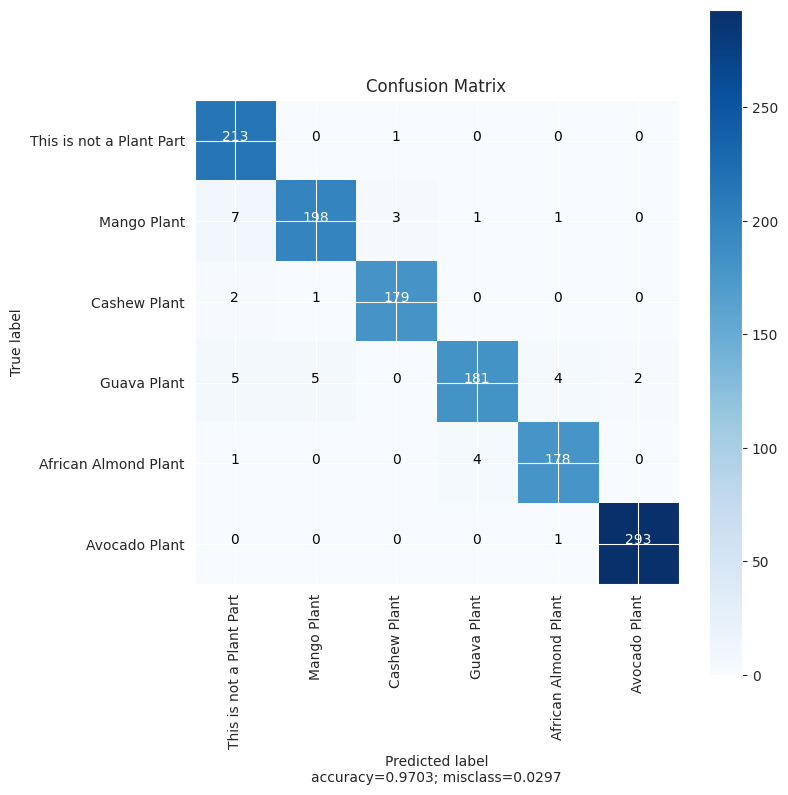

In [29]:
plot_confusion_matrix(cm,
                      normalize    = False,
                      target_names = ['This is not a Plant Part',
                                      'Mango Plant',
                                      'Cashew Plant',
                                      'Guava Plant',
                                      'African Almond Plant',
                                      'Avocado Plant'],
                      title        = "Confusion Matrix")

In [30]:
# Save Model
models.save_model(model, '/content/drive/MyDrive/inceptionv3/Plants.h5')

In [31]:
model = tf.keras.models.load_model('/content/drive/MyDrive/inceptionv3/Plants.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open("/content/drive/MyDrive/inceptionv3/model.tflite", "wb").write(tflite_model)

95782016